In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

color_pal = sns.color_palette()

/home/ve1nard/miniconda3/envs/ml_proj/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [39]:
df = pd.read_csv("./PJME_hourly.csv")
df.set_index("Datetime", inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

<Axes: title={'center': 'Energy Use in MW'}, xlabel='Datetime'>

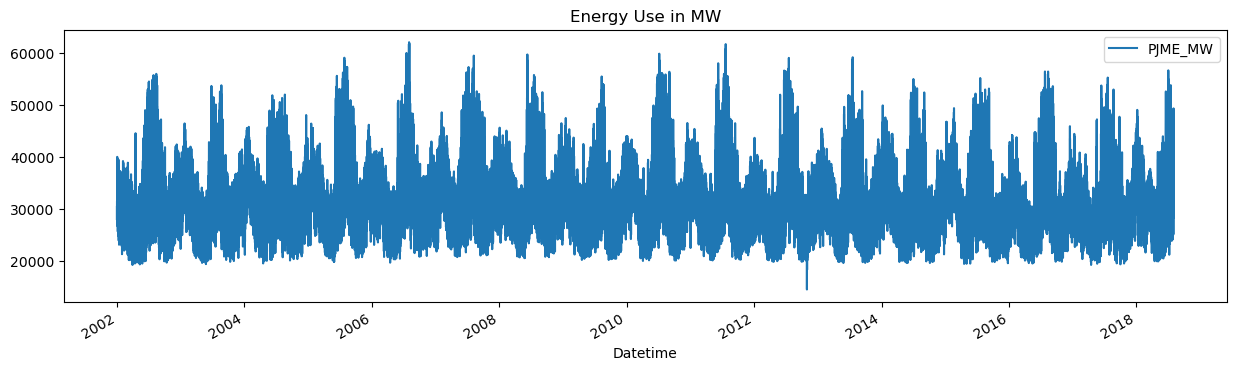

In [40]:
df.plot(style="-", 
        figsize=(15,4), 
        color=color_pal[0], 
        title='Energy Use in MW')

## Train / Test split

Text(0.5, 1.0, 'Data Train/Test Split')

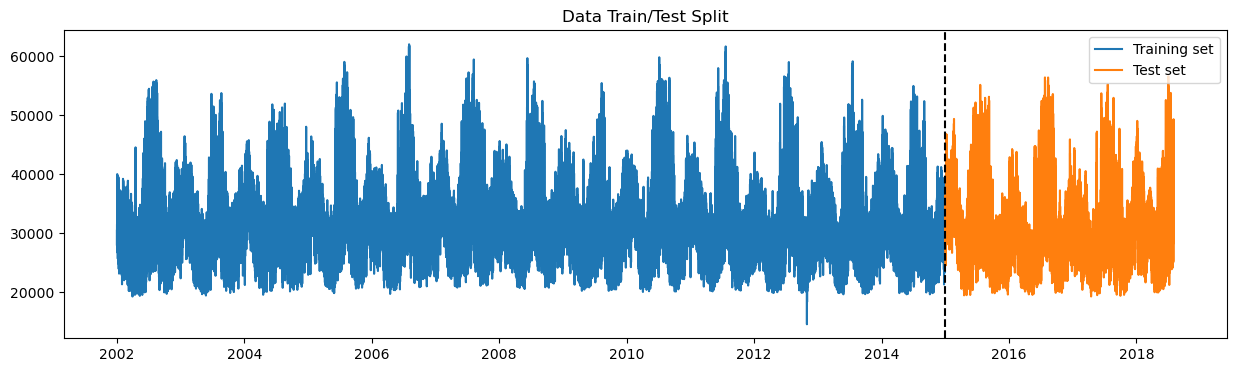

In [41]:
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(train.index, train['PJME_MW'], label='Training set')
ax.plot(test.index, test['PJME_MW'], label='Test set')
ax.axvline(pd.to_datetime('2015-01-01'), color='black', ls='--')
ax.legend()
ax.set_title('Data Train/Test Split')

<Axes: xlabel='Datetime'>

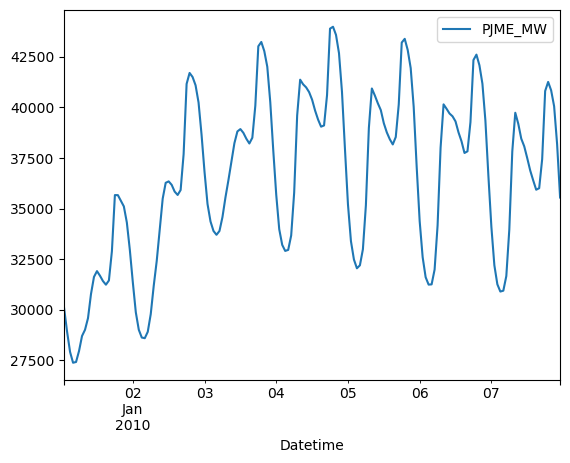

In [42]:
# Visualize the energy consumption rates within one week
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].plot()

## Feature creation

In [ ]:
def create_features(df):
    """"
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.isocalendar().day
    df['week'] = df.index.isocalendar().week
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.isocalendar().year

    return df

df = create_features(df)

## Visualize the Feature-Target relationship

Text(0.5, 1.0, 'MW by Hour')

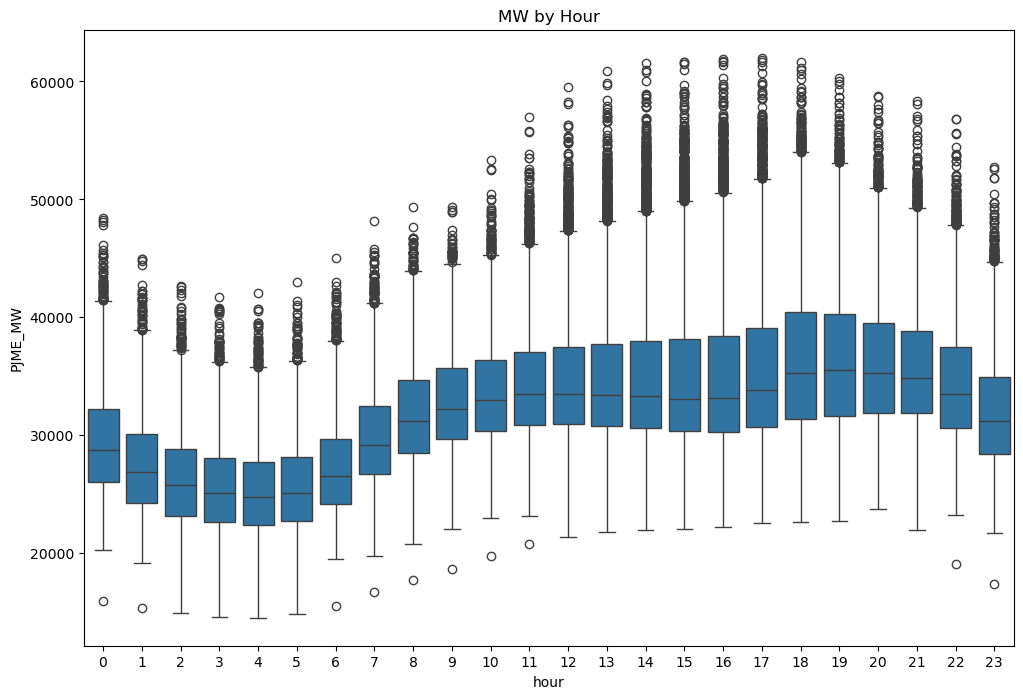

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')

Text(0.5, 1.0, 'MW by Month')

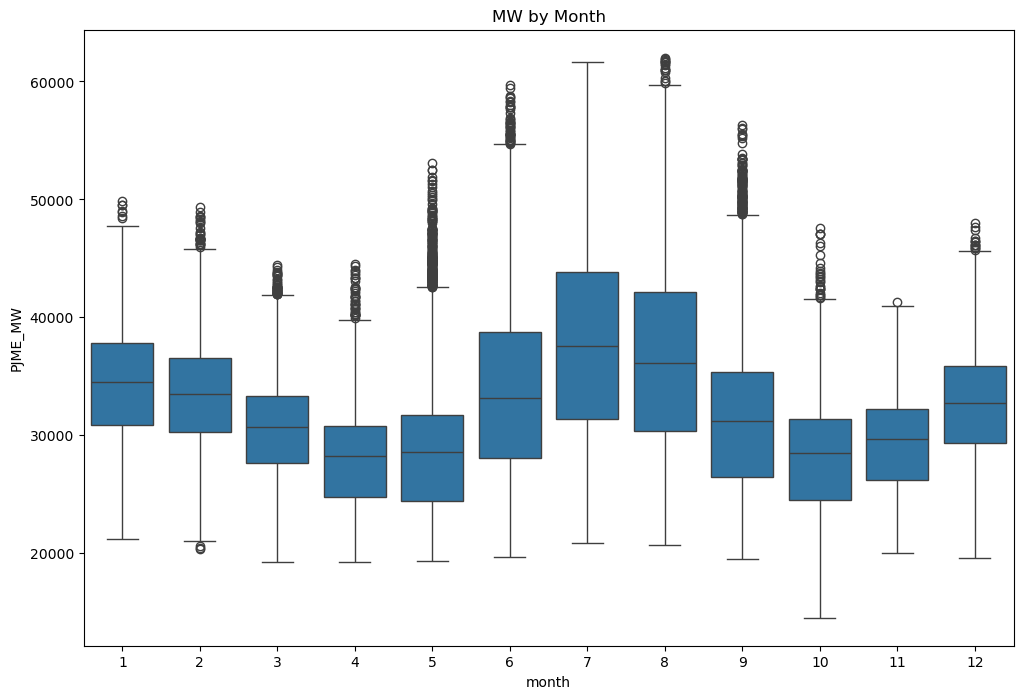

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')

## Create our model

In [46]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'dayofyear', 'month', 'quarter', 'year']
TARGET = 'PJME_MW'

In [47]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [71]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=250,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])
_=None

[0]	validation_0-rmse:31657.15729	validation_1-rmse:32605.13970
[1]	validation_0-rmse:31338.35548	validation_1-rmse:32286.40387
[2]	validation_0-rmse:31022.82517	validation_1-rmse:31970.92515


[3]	validation_0-rmse:30710.54618	validation_1-rmse:31658.67497
[4]	validation_0-rmse:30403.04162	validation_1-rmse:31349.61580
[5]	validation_0-rmse:30097.13477	validation_1-rmse:31043.71359
[6]	validation_0-rmse:29795.93347	validation_1-rmse:30740.94175
[7]	validation_0-rmse:29496.27413	validation_1-rmse:30441.26143
[8]	validation_0-rmse:29201.25018	validation_1-rmse:30144.64955
[9]	validation_0-rmse:28907.72364	validation_1-rmse:29851.07579
[10]	validation_0-rmse:28618.76046	validation_1-rmse:29560.50774
[11]	validation_0-rmse:28331.47224	validation_1-rmse:29272.91646
[12]	validation_0-rmse:28048.45508	validation_1-rmse:28988.27243
[13]	validation_0-rmse:27767.05438	validation_1-rmse:28706.54403
[14]	validation_0-rmse:27489.86317	validation_1-rmse:28427.71157
[15]	validation_0-rmse:27214.23689	validation_1-rmse:28151.73487
[16]	validation_0-rmse:26942.55987	validation_1-rmse:27878.59542
[17]	validation_0-rmse:26672.59913	validation_1-rmse:27608.25699
[18]	validation_0-rmse:26406.523

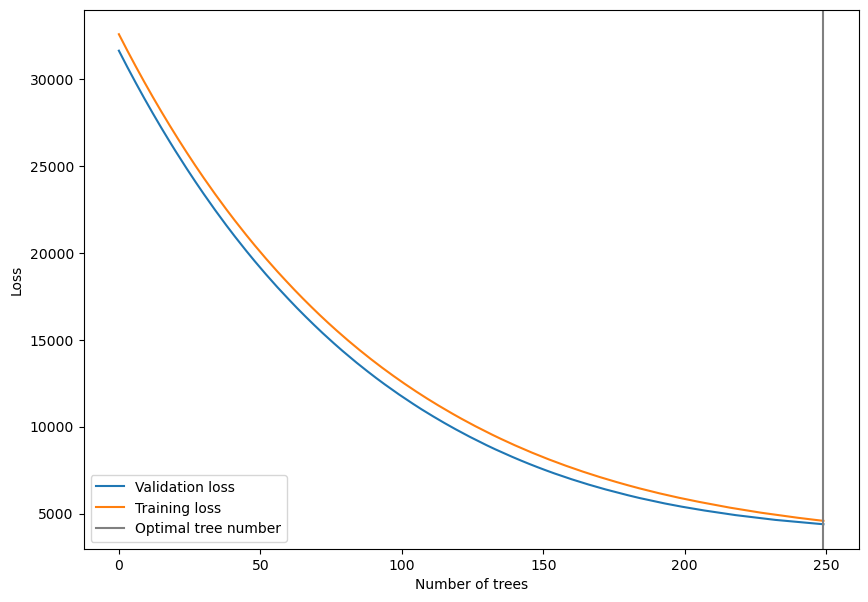

In [72]:
results = reg.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results['validation_0']['rmse'], label='Validation loss')
plt.plot(results['validation_1']['rmse'], label='Training loss')
best = reg.best_iteration
plt.axvline(best, color='gray', label='Optimal tree number')
plt.xlabel('Number of trees')
plt.ylabel('Loss')
plt.legend()

## Feature importance

<Axes: title={'center': 'Feature Importance'}>

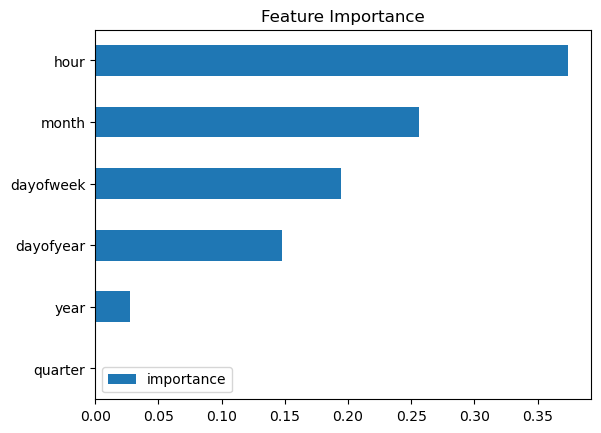

In [58]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values(by='importance').plot(kind='barh', title='Feature Importance')

In [76]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)
print(df)

                     PJME_MW  hour  dayofweek  dayofyear  month  quarter  \
Datetime                                                                   
2002-01-01 01:00:00  30393.0     1          1          1      1        1   
2002-01-01 02:00:00  29265.0     2          1          1      1        1   
2002-01-01 03:00:00  28357.0     3          1          1      1        1   
2002-01-01 04:00:00  27899.0     4          1          1      1        1   
2002-01-01 05:00:00  28057.0     5          1          1      1        1   
...                      ...   ...        ...        ...    ...      ...   
2018-08-02 20:00:00  44057.0    20          3        214      8        3   
2018-08-02 21:00:00  43256.0    21          3        214      8        3   
2018-08-02 22:00:00  41552.0    22          3        214      8        3   
2018-08-02 23:00:00  38500.0    23          3        214      8        3   
2018-08-03 00:00:00  35486.0     0          4        215      8        3   

           

/tmp/ipykernel_18911/2410116081.py:2: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(df['prediction'], '-')


Text(0.5, 1.0, 'Raw data and prediction')

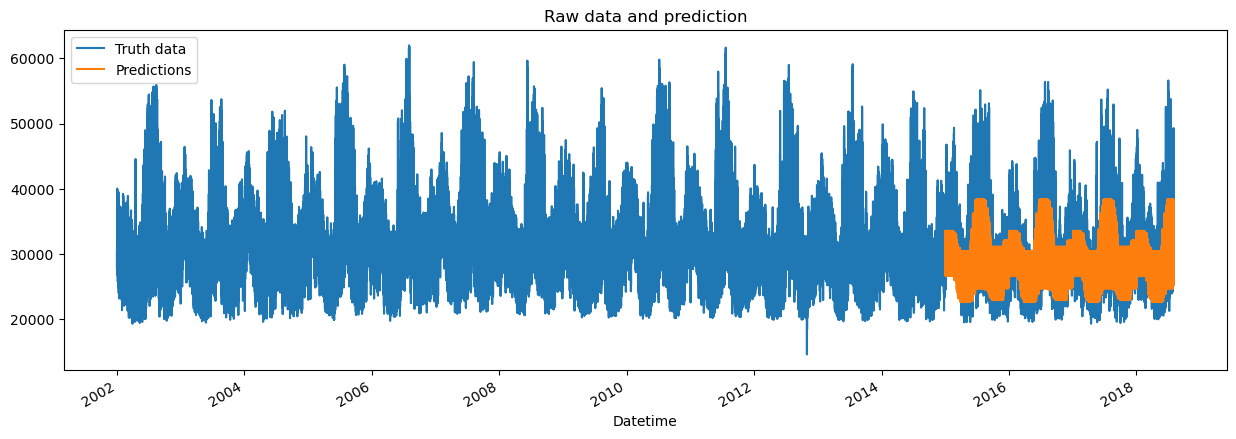

In [77]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
ax.plot(df['prediction'], '-')
plt.legend(['Truth data', 'Predictions'])
ax.set_title('Raw data and prediction')

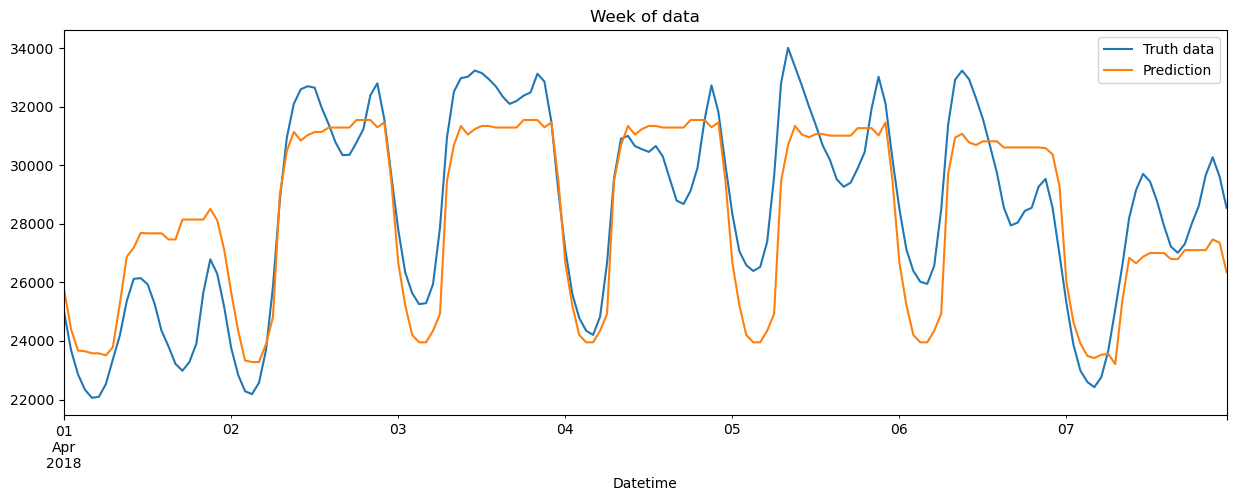

In [64]:
ax = df.loc[(df.index >= '2018-04-01') & (df.index < '2018-04-08')]['PJME_MW'].plot(figsize=(15,5), title='Week of data', label='Truth data')
df.loc[(df.index >= '2018-04-01') & (df.index < '2018-04-08')]['prediction'].plot(style='-', label='Prediction')
plt.legend()

In [78]:
score= np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on the Test set: {score:0.2f}')

RMSE Score on the Test set: 4383.22


## More advanced feature engineering and hyperparameter search

<Axes: ylabel='Frequency'>

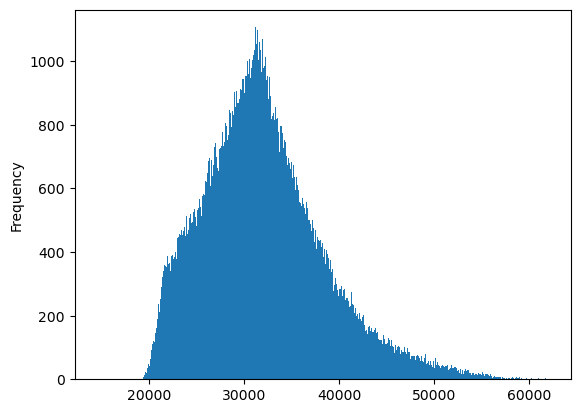

In [17]:
df = pd.read_csv('./PJME_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

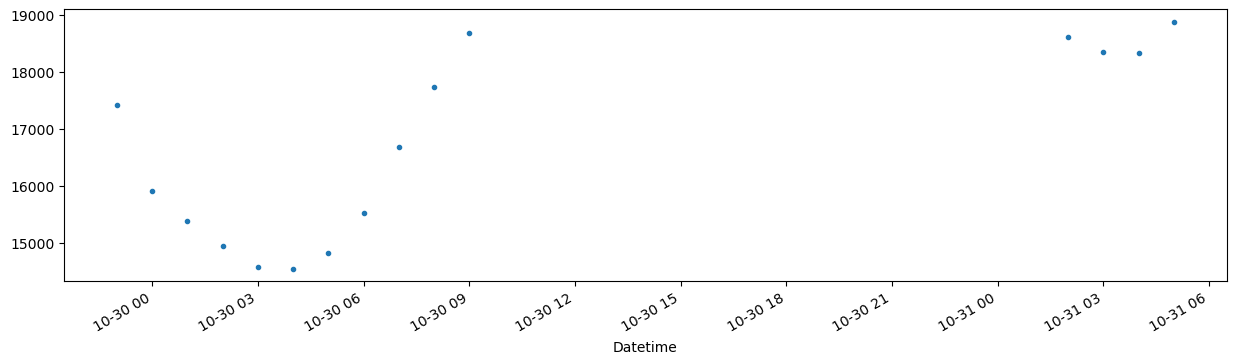

In [7]:
df[df['PJME_MW'] < 19_000]['PJME_MW'].plot(figsize=(15,4), style='.')

In [14]:
df = df.query('PJME_MW > 19_000').copy()

In [15]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df.sort_index(inplace=True)

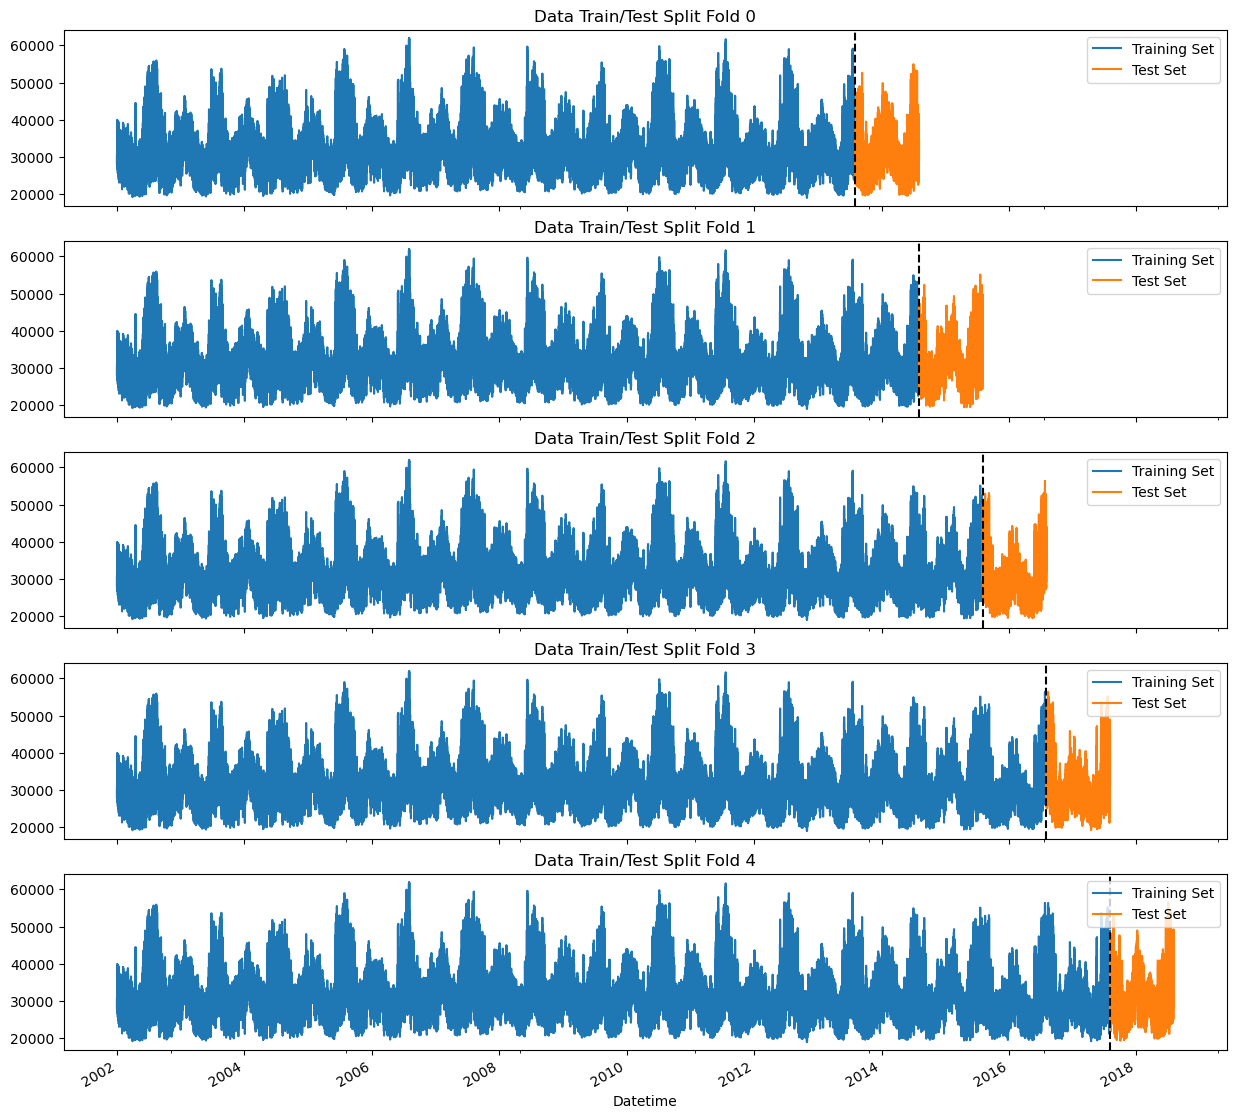

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(df):
    train_fold = df.iloc[train_idx]
    test_fold = df.iloc[test_idx]
    train_fold['PJME_MW'].plot(ax=axs[fold],
                               label='Training Set',
                               title=f'Data Train/Test Split Fold {fold}')
    test_fold['PJME_MW'].plot(ax=axs[fold], 
                              label='Test Set')
    axs[fold].axvline(test_fold.index.min(), color='black', linestyle='--')
    axs[fold].legend()
    fold += 1

In [16]:
print(df.index.is_unique)
print(df.index[df.index.duplicated()])

False
DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


## Creating More Features

In [2]:
def create_features(df):
    """"
    Create time series features based on time series index.
    """
    df = df.copy()

    # Add basic time features, including hour, day of the week (1-7),
    # day of the year, month, quarter, year
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.isocalendar().day.astype(int)
    df['week'] = df.index.isocalendar().week.astype(int)
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.isocalendar().year.astype(int)

    # Add a feature representing weekends
    df['is_weekend'] = df['dayofweek'].isin([6, 7]).astype(int)

    # Add lag features representing energy consumption
    #  at the same time stamp in the last 1,2, and 3 years 
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta(days=364)).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta(days=728)).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta(days=1092)).map(target_map)

    # Add rolling window features to calculate the mean energy 
    # consumption over the past month and past week
    df['prev_week_mean'] = df['PJME_MW'].rolling('7D').mean().shift(freq='1D')
    df['prev_month_mean'] = df['PJME_MW'].rolling('30D').mean().shift(freq='1D')

    # Add a feature representing the average energy consumption 
    # over the same week number in the previous year
    weekly_sales = df.groupby(['year', 'week']).mean().reset_index()
    weekly_sales.rename(columns={
        'year' : 'matchyear', 
        'week' : 'matchweek',
        'PJME_MW' : 'mean_PJME_MW'
    }, inplace=True)
    df['previous_year'] = df['year'] - 1
    df_index = df.index
    df = pd.merge(
        df,
        weekly_sales[['matchyear', 'matchweek', 'mean_PJME_MW']],
        how='left', 
        left_on=['previous_year', 'week'],
        right_on=['matchyear', 'matchweek'])
    df.drop(columns=['matchyear', 'matchweek', 'previous_year'], inplace=True)
    df.index = df_index

    # Lag3 feature results in the first 3 years (2002-2005) of data having NaN mean values,
    # thus we remove the entries within this time frame
    df = df[df.index >= '2006-01-01']

    # Add a feature representing the number of days passed since the 
    # the maximum energy consumption for this month
    df['date'] = df.index.normalize()
    for (y, m), month_group in df.groupby(['year', 'month']):
        for current_date, day_group in month_group.groupby('date'):
            days_up_to_current = month_group[(month_group['date'] >= current_date - pd.Timedelta(days=3)) & (month_group['date'] <= current_date)]
            max_day_id = days_up_to_current['PJME_MW'].idxmax()
            min_day_id = days_up_to_current['PJME_MW'].idxmin()
            max_date = df.loc[max_day_id, 'date']
            min_date = df.loc[min_day_id, 'date']
            days_since_prev_max = (current_date - max_date).days
            days_since_prev_min = (current_date - min_date).days
            df.loc[day_group.index, 'days_since_prev_max'] = days_since_prev_max
            df.loc[day_group.index, 'days_since_prev_min'] = days_since_prev_min
    df.drop(columns=['date'])

    return df

In [12]:
print(df.index.is_unique)
print(df.index[df.index.duplicated()])

False
DatetimeIndex(['2014-11-02 02:00:00', '2015-11-01 02:00:00',
               '2016-11-06 02:00:00', '2017-11-05 02:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)


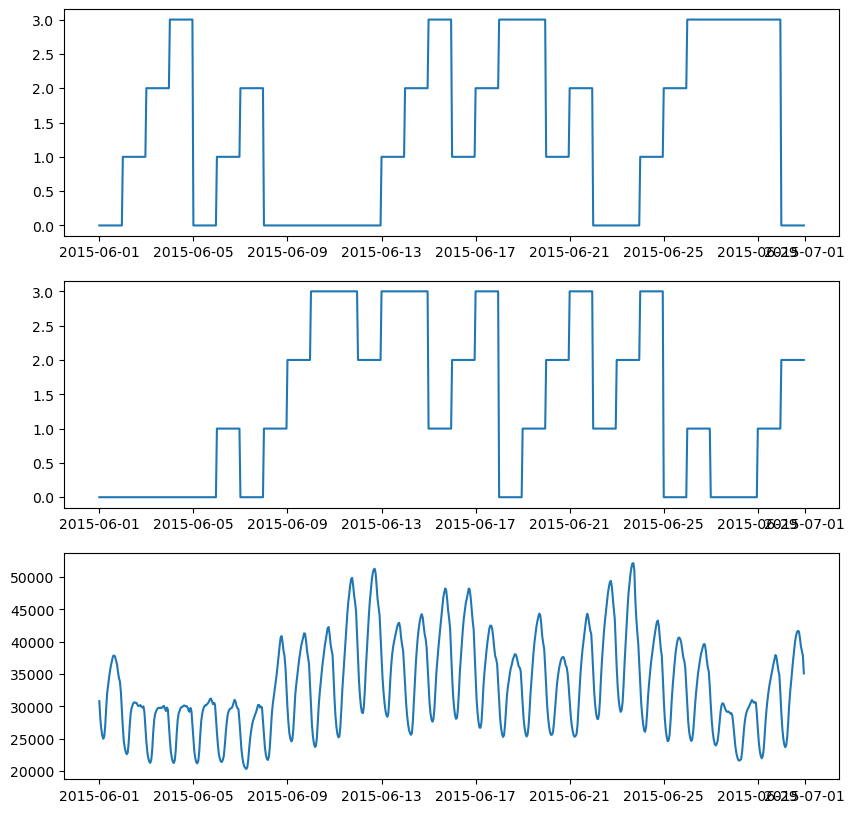

In [100]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df[(df['year'] == 2015) & (df['month'] == 6)]['days_since_prev_max'])
axs[1].plot(df[(df['year'] == 2015) & (df['month'] == 6)]['days_since_prev_min'])
axs[2].plot(df[(df['year'] == 2015) & (df['month'] == 6)]['PJME_MW'])


In [ ]:
preds, scores = [], []
for train_idx, test_idx in tss.split(df):
    train_fold = df.iloc[train_idx]
    test_fold = df.iloc[test_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3', 'mean_PJME_MW', 'is_weekend', 'prev_week_mean', 
            'prev_month_mean', 'days_since_prev_max', 'days_since_prev_min']
    TARGET = 'PJME_MW'

    X_train = train_fold[FEATURES]
    y_train = train_fold[TARGET]

    X_test = test_fold[FEATURES]
    y_test = test_fold[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train, 
            eval_set=[(X_test, y_test), (X_train, y_train)], 
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    

[0]	validation_0-rmse:31960.41430	validation_1-rmse:32839.47095
[100]	validation_0-rmse:12097.53732	validation_1-rmse:12433.35876
[200]	validation_0-rmse:5308.22566	validation_1-rmse:5301.82675
[300]	validation_0-rmse:3424.44666	validation_1-rmse:3161.58861
[400]	validation_0-rmse:3010.38202	validation_1-rmse:2646.42420
[500]	validation_0-rmse:2890.42769	validation_1-rmse:2497.01912
[600]	validation_0-rmse:2839.00857	validation_1-rmse:2425.83189
[700]	validation_0-rmse:2803.88309	validation_1-rmse:2378.52241
[800]	validation_0-rmse:2778.93296	validation_1-rmse:2340.73458
[900]	validation_0-rmse:2761.42750	validation_1-rmse:2309.84046
[999]	validation_0-rmse:2750.35976	validation_1-rmse:2284.10714
[0]	validation_0-rmse:32145.08038	validation_1-rmse:32738.75970
[100]	validation_0-rmse:12440.27047	validation_1-rmse:12406.74382
[200]	validation_0-rmse:5569.63162	validation_1-rmse:5312.41783
[300]	validation_0-rmse:3491.76949	validation_1-rmse:3190.71605
[400]	validation_0-rmse:2951.20052	v

In [70]:
scores

[np.float64(4108.727266320072),
 np.float64(3419.549507172219),
 np.float64(3822.193556289229),
 np.float64(4067.7191519641146),
 np.float64(4078.4339779360776)]

In [71]:
print(f'Score across folds {np.mean(scores):0.4f}')
print('Fold scores:')
for score in scores:
    print(f'{score}')

Score across folds 3899.3247
Fold scores:
4108.727266320072
3419.549507172219
3822.193556289229
4067.7191519641146
4078.4339779360776


## Training On The Full Dataset With Hyperparameter Tuning And Predicting On The Test Set

### Data retrieval, feature engineering, and train/test splitting

In [3]:
df = pd.read_csv('./PJME_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
# Mark unique indices and first occurences of duplicates as true
# to remove the rest of the duplicates
df = df[~df.index.duplicated(keep='first')]
# Based on EDA, remove outliers with energy consumption higher than 19,000 MW
df = df.query('PJME_MW > 19_000').copy()
# Sort by index
df.sort_index(inplace=True)
# Feature engineering
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3', 'mean_PJME_MW', 'is_weekend', 'prev_week_mean', 
            'prev_month_mean', 'days_since_prev_max', 'days_since_prev_min']
TARGET = 'PJME_MW'

X_train = df.loc[df.index < '2017-08-03'][FEATURES]
y_train = df.loc[df.index < '2017-08-03'][TARGET]
base_prediction = df.loc[df.index == '2017-08-02'][TARGET].mean()

X_test = df.loc[df.index >= '2017-08-03'][FEATURES]
y_test = df.loc[df.index >= '2017-08-03'][TARGET]

### Grid Search Hyperparameter Tuning

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import time

parameters = {
    'base_score' : [base_prediction],
    'n_estimators' : [100, 500, 1000],
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [2, 4, 6],
    'reg_alpha' : [0.01, 0.1, 1.0],
    'reg_lambda' : [0.01, 0.1, 1.0]
}
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1)

reg_grid = GridSearchCV(xgb.XGBRegressor(n_jobs=1), param_grid=parameters, scoring='neg_mean_squared_error', cv=tss, n_jobs=-1)

start_time = time.time()
reg_grid.fit(X_train, y_train)
duration = time.time() - start_time

/home/ve1nard/miniconda3/envs/ml_proj/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ve1nard/miniconda3/envs/ml_proj/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

In [6]:
print(f'Grid Search Hyperparameter tuning was completed in {duration} with the error of {np.sqrt(-reg_grid.best_score_):.2f} MW')
print(reg_grid.best_params_)

y_pred = reg_grid.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'The test error is {score:.2f} MW')

Grid Search Hyperparameter tuning was completed in 1397.4253151416779 with the error of 2847.36 MW
{'base_score': np.float64(35126.0), 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 1.0}
The test error is 3067.22 MW


### Randomized Grid Search Hyperparameter Tuning

In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import time
from scipy.stats import randint, uniform, loguniform

parameters = {
    'base_score' : [base_prediction],
    'n_estimators' : randint(low=100, high=1000),
    'learning_rate' : loguniform(a=0.01, b=0.3),
    'max_depth' : randint(low=3, high=10),
    'reg_alpha' : loguniform(a=1e-5, b=10.0),
    'reg_lambda' : loguniform(a=1e-5, b=10.0)
}
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1)

reg_rand = RandomizedSearchCV(xgb.XGBRegressor(n_jobs=1), param_distributions=parameters, scoring='neg_mean_squared_error', n_iter=100, cv=tss, random_state=42, n_jobs=-1)

start_time = time.time()
reg_rand.fit(X_train, y_train)
duration = time.time() - start_time

/home/ve1nard/miniconda3/envs/ml_proj/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ve1nard/miniconda3/envs/ml_proj/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

In [8]:
print(f'Randomized Grid Search Hyperparameter tuning was completed in {duration} with the training error of {np.sqrt(-reg_rand.best_score_):.2f} MW')
print(reg_rand.best_params_)

y_pred = reg_rand.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'The test error is {score:.2f} MW')

Randomized Grid Search Hyperparameter tuning was completed in 685.6611547470093 with the training error of 2807.97 MW
{'base_score': np.float64(35126.0), 'learning_rate': np.float64(0.014050436029337603), 'max_depth': 6, 'n_estimators': 495, 'reg_alpha': np.float64(5.639608822920902), 'reg_lambda': np.float64(1.210204781731547)}
The test error is 2995.41 MW


### Bayesian Hyperparameter Tuning

In [9]:
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import time
from scipy.stats import randint, uniform, loguniform

parameters = {
    'base_score' : [base_prediction],
    'n_estimators' : Integer(100, 1000, prior='uniform'),
    'learning_rate' : Real(0.001, 0.05, prior='log-uniform'),
    'max_depth' : Integer(3, 7, prior='uniform'),
    'reg_alpha' : Real(1e-5, 0.001, prior='uniform'),
    'reg_lambda' : Real(0.1, 5.0, prior='uniform')
}
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1)

reg_bayes = BayesSearchCV(xgb.XGBRegressor(n_jobs=1), search_spaces=parameters, scoring='neg_mean_squared_error', n_iter = 100, cv=tss, random_state=42, n_jobs=-1)

start_time = time.time()
reg_bayes.fit(X_train, y_train)
duration = time.time() - start_time

/home/ve1nard/miniconda3/envs/ml_proj/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ve1nard/miniconda3/envs/ml_proj/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

In [11]:
print(f'Bayesian Grid Search Hyperparameter tuning was completed in {duration} with the error of {np.sqrt(-reg_bayes.best_score_):.2f} MW')
print(reg_bayes.best_params_)

y_pred = reg_bayes.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'The test error is {score:.2f} MW')

Bayesian Grid Search Hyperparameter tuning was completed in 855.1762912273407 with the error of 2800.21 MW
OrderedDict({'base_score': 35126.0, 'learning_rate': 0.049999999999999996, 'max_depth': 6, 'n_estimators': 142, 'reg_alpha': 1e-05, 'reg_lambda': 5.0})
The test error is 3000.68 MW


## Creating Future Dates To Predict For

In [121]:
future_w_features = df_and_future.query('isFuture').copy()

<Axes: title={'center': 'Future Predictions'}>

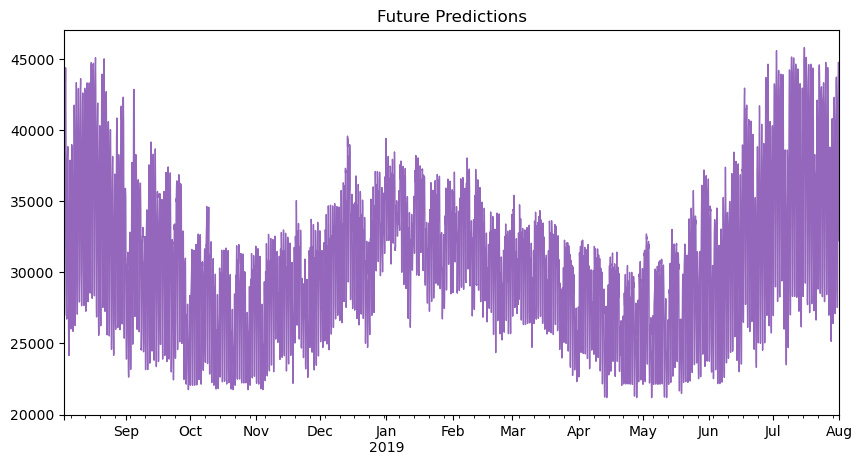

In [124]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')